# Start to end test

Before runing this test, please download models from [https://nomeroff.net.ua/models/](https://nomeroff.net.ua/models/) to **./models/** directory. 

In [3]:
import os
import sys
import json
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from termcolor import colored
import warnings
warnings.filterwarnings('ignore')

# change this property
NOMEROFF_NET_DIR = os.path.abspath('../')

# specify the path to Mask_RCNN if you placed it outside Nomeroff-net project
MASK_RCNN_DIR = os.path.join(NOMEROFF_NET_DIR, 'Mask_RCNN')

MASK_RCNN_LOG_DIR = "../logs/"
MASK_RCNN_MODEL_PATH = "../models/mask_rcnn_numberplate_0700.pb"
OPTIONS_MODEL_PATH =  "../models/numberplate_options_2019_2_15.pb"
OCR_NP_UKR_TEXT =  "../models/anpr_ocr_ua_1_2_11-cpu.pb"
OCR_NP_EU_TEXT =  "../models/anpr_ocr_eu_2-cpu.pb"

sys.path.append(NOMEROFF_NET_DIR)

In [4]:
from NomeroffNet import  filters, RectDetector, TextDetector, OptionsDetector, Detector, textPostprocessingAsync

nnet = Detector(MASK_RCNN_DIR, MASK_RCNN_LOG_DIR)
nnet.load(MASK_RCNN_MODEL_PATH)

rectDetector = RectDetector()

optionsDetector = OptionsDetector()
optionsDetector.load(OPTIONS_MODEL_PATH)

# Initialize text detector.
textDetector = TextDetector({
    "eu_ua_2014_2015": {
        "for_regions": ["eu_ua_2015", "eu_ua_2004"],
        "model_path": OCR_NP_UKR_TEXT
    },
    "eu": {
        "for_regions": ["eu", "eu_ua_1995"],
        "model_path": OCR_NP_EU_TEXT
    }
})

In [5]:
import cv2
import numpy as np

async def test(dirName, fname, y, verbose=0, max_img_w = 1280):
    img_path = os.path.join(dirName, fname)
    if verbose==1:
        print(colored(f"__________ \t\t {img_path} \t\t __________", "blue"))
    img = mpimg.imread(img_path)
    nGood = 0
    nBad = 0
    img_path = os.path.join(dirName, fname)
    if verbose:
        print(img_path)
    img = mpimg.imread(img_path)

    # corect size for better speed
    img_w = img.shape[1]
    img_h = img.shape[0]
    img_w_r = 1
    img_h_r = 1
    if img_w > max_img_w:
        resized_img = cv2.resize(img, (max_img_w, int(max_img_w/img_w*img_h)))
        img_w_r = img_w/max_img_w
        img_h_r = img_h/(max_img_w/img_w*img_h)
    else:
        resized_img = img

    NP = nnet.detect([resized_img]) 
    
    # Generate image mask.
    cv_img_masks = await filters.cv_img_mask_async(NP)

    # Detect points.
    arrPoints = await rectDetector.detectAsync(cv_img_masks, outboundHeightOffset=3-img_w_r)
    arrPoints[..., 1:2] = arrPoints[..., 1:2]*img_h_r
    arrPoints[..., 0:1] = arrPoints[..., 0:1]*img_w_r

    # cut zones
    zones = await rectDetector.get_cv_zonesBGR_async(img, arrPoints)
    toShowZones = rectDetector.get_cv_zonesRGB(img, arrPoints)
    if verbose:
        for zone, points in zip(toShowZones, arrPoints):
            plt.axis("off")
            plt.imshow(zone)
            plt.show()

    # find standart
    regionIds, stateIds = optionsDetector.predict(zones)
    regionNames = optionsDetector.getRegionLabels(regionIds)
    if verbose:
        print(regionNames)

    # find text with postprocessing by standart  
    textArr = textDetector.predict(zones, regionNames)
    textArr = await textPostprocessingAsync(textArr, regionNames)
    if verbose:
        print(textArr)
    
    for yText in y:
        if yText in textArr:
            print(colored(f"OK: TEXT:{yText} \t\t\t RESULTS:{textArr} \n\t\t\t\t\t in PATH:{img_path}", 'green'))
            nGood += 1
        else:
            print(colored(f"NOT OK: TEXT:{yText} \t\t\t RESULTS:{textArr} \n\t\t\t\t\t in PATH:{img_path} ", 'red'))
            nBad += 1
    return nGood, nBad

In [6]:
dirName = "images/"

In [7]:
testData = {
    "0.jpeg": ["AI5255EI"],
    "1.jpeg": ["HH7777CC"],
    "2.jpeg": ["AT1515CK"],
    "3.jpeg": ["BX0578CE"],
    "4.jpeg": ["AC4249CB"],
    "5.jpeg": ["BC3496HC"],
    "6.jpeg": ["BC3496HC"],
    "7.jpeg": ["AO1306CH"],
    "8.jpeg": ["AE1077CO"],
    "9.jpeg": ["AB3391AK"],
    "10.jpeg": ["BE7425CB"],
    "11.jpeg": ["BE7425CB"],
    "12.jpeg": ["AB0680EA"],
    "13.jpeg": ["AB0680EA"],
    "14.jpeg": ["BM1930BM"],
    "15.jpeg": ["AI1382HB"],
    "16.jpeg": ["AB7333BH"],
    "17.jpeg": ["AB7642CT"],
    "18.jpeg": ["AC4921CB"],
    "19.jpeg": ["BC9911BK"],
    "20.jpeg": ["BC7007AK"],
    "21.jpeg": ["AB5649CI"],
    "22.jpeg": ["AX2756EK"],
    "23.jpeg": ["AA7564MX"],
    "24.jpeg": ["AM5696CK"],
    "25.jpeg": ["AM5696CK"],
}

gGood = 0
gBad = 0
i = 0
for fileName in testData.keys():
    nGood, nBad = await test(dirName, fileName, testData[fileName], verbose=0)
    gGood += nGood
    gBad += nBad
    i += 1
total = gGood + gBad
print(f"TOTAL GOOD: {gGood/total}")
print(f"TOTAL BED: {gBad/total}")

OK: TEXT:AI5255EI 			 RESULTS:['AI5255EI'] 
					 in PATH:images/0.jpeg
OK: TEXT:HH7777CC 			 RESULTS:['HH7777CC'] 
					 in PATH:images/1.jpeg
OK: TEXT:AT1515CK 			 RESULTS:['AT1515CK', 'RP69881'] 
					 in PATH:images/2.jpeg
OK: TEXT:BX0578CE 			 RESULTS:['BX0578CE'] 
					 in PATH:images/3.jpeg
OK: TEXT:AC4249CB 			 RESULTS:['AC4249CB'] 
					 in PATH:images/4.jpeg
OK: TEXT:BC3496HC 			 RESULTS:['BC3496HC'] 
					 in PATH:images/5.jpeg
OK: TEXT:BC3496HC 			 RESULTS:['BC3496HC'] 
					 in PATH:images/6.jpeg
OK: TEXT:AO1306CH 			 RESULTS:['AO1306CH'] 
					 in PATH:images/7.jpeg
OK: TEXT:AE1077CO 			 RESULTS:['AE1077CO'] 
					 in PATH:images/8.jpeg
OK: TEXT:AB3391AK 			 RESULTS:['AB3391AK'] 
					 in PATH:images/9.jpeg
OK: TEXT:BE7425CB 			 RESULTS:['BE7425CB'] 
					 in PATH:images/10.jpeg
OK: TEXT:BE7425CB 			 RESULTS:['BE7425CB'] 
					 in PATH:images/11.jpeg
OK: TEXT:AB0680EA 			 RESULTS:['AB0680EA', ''] 
					 in PATH:images/12.jpeg
OK: TEXT:AB0680EA 			 RESULTS:['AB0680EA', '',

__________ 		 images/2.jpeg 		 __________
images/2.jpeg


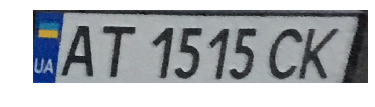

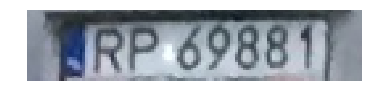

['eu_ua_2015', 'eu']
['AT1515CK', 'RP69881']
OK: TEXT:AT1515CK 			 RESULTS:['AT1515CK', 'RP69881'] 
					 in PATH:images/2.jpeg


(1, 0)

In [8]:
await test(dirName, "2.jpeg", ["AT1515CK"], verbose=1)